<a href="https://colab.research.google.com/github/Rafikul10/Flowers-Classification-PyTorch/blob/main/Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Flower Species using Deep Learning and PyTorch

TODO - Introduction

We are going to do it in following steps:

1. Pick a dataset
2. Download the dataset
3. Import the daatset using pytorch
4. Explore the dataset
5. Prepare the dataset for training
6. Move the dataset to GPU
7. Define a neural networks
8. Train the model
9. Make predictions on sample images itrate on it with different networks and hyperparameters

### Download the Dataset

Using `opendatasets` and download the
dataste from https://www.kaggle.com/datasets/alxmamaev/flowers-recognition .

In [1]:
!pip install opendatasets --upgrade --quiet 

In [2]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [4]:
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [5]:
data_dir = './flowers-recognition/flowers'

In [6]:
import os

In [7]:
os.listdir(data_dir)

['daisy', 'rose', 'tulip', 'sunflower', 'dandelion']

In [8]:
#For remove the directory from datasets
#import shutil
#shutil.rmtree(data_dir(path of dir) + '/directory-name')

In [9]:
for cls in os.listdir(data_dir):
  print(cls, len(os.listdir(data_dir + '/' + cls)))

daisy 764
rose 784
tulip 984
sunflower 733
dandelion 1052


### Import the Dataset Into PyTorch

Use the `ImageFolder` class from `torchvision`.

In [10]:
from torchvision.datasets import ImageFolder

In [11]:
dataset = ImageFolder(data_dir)

In [12]:
len(dataset)

4317

In [13]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F487B82DCD0>, 0)

In [14]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

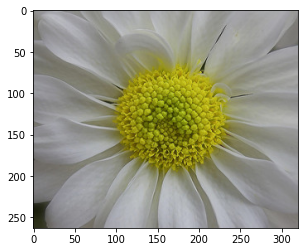

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

img, label = dataset[0]
plt.imshow(img)

In [16]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

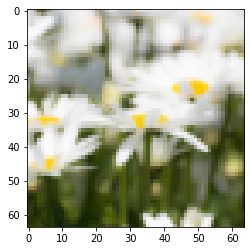

In [17]:
img, label = dataset[100]
plt.imshow(img.permute(1, 2, 0))
#If we don't use permute then there one error will be occur bcz
#first its required shape of the image to plot 

In [18]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [19]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [20]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(20,16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

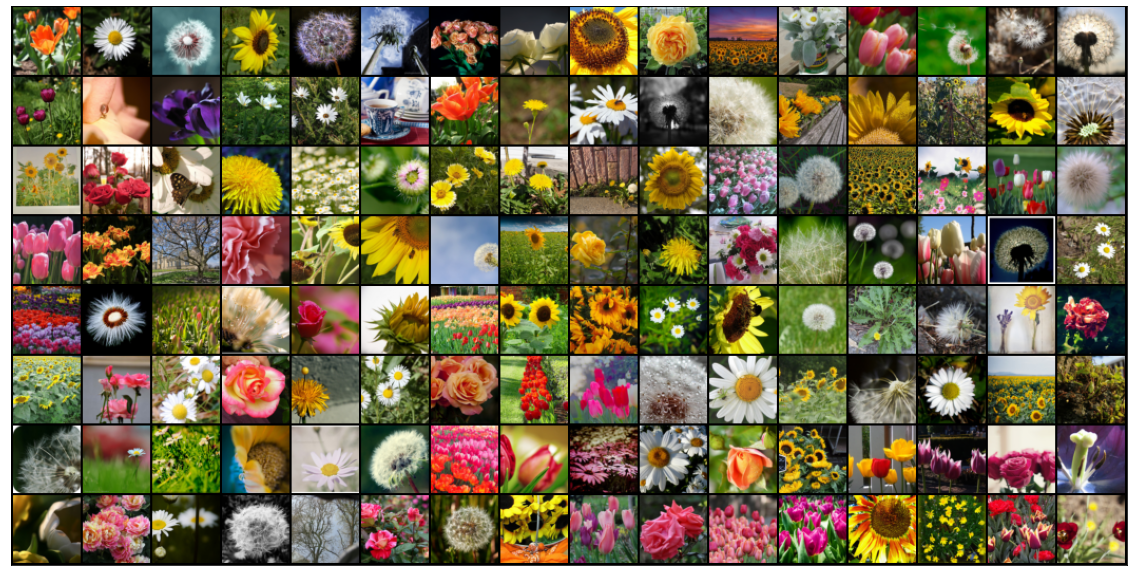

In [22]:
show_batch(train_dl)

### GPU Utilities

In [23]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
torch.cuda.is_available()

False

In [25]:
device = get_default_device()

In [26]:
device

device(type='cpu')

In [27]:
img, label = dataset[0]

In [28]:
img.device

device(type='cpu')

In [29]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cpu')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Model and Training utilities

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [33]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [34]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [35]:
model.conv1[0].weight.device

device(type='cpu')

Pass one batch of input tensor through the model

In [36]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cpu
preds.shape torch.Size([128, 5])


### Training

In [37]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6112885475158691, 'val_acc': 0.21530085802078247}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4491, val_loss: 1.7284, val_acc: 0.3144


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.SGD)

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

### Record the Result

In [ ]:
!pip install jovian --quiet

In [ ]:
history[-1]

In [ ]:
import jovian
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128,
                       arch='ResNet9',
                       epochs=[5, 5, 5, 5],
                       lrs=[0.001, 0.001, 1e-4, 1e-4],
                       opt=['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                  val_acc=history[-1]["val_acc"],
                  val_loss=history[-1]["val_loss"])

In [ ]:
jovian.commit(project='deep-learning-project')

### Test with Individual Images

In [ ]:
def predict_image(img, model, classes):
  # Conver to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with high probability
  _, preds = torch.max(yb, dim=1)
  # Retrive the class label
  return dataset.classes[preds[0].item()]

In [ ]:
def show_iamge_prediction(img, label):
  plt.imshow(img.permute(1, 2, 0))
  pred = predict_image(img, model, dataset.classes)
  print('Target', dataset.classses[label])
  print('Prediction', pred)

In [ ]:
show_image_prediction(*valid_ds[100])

###Transfer Learning

In [ ]:
class ResNet34(ImageClassificationBase):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    # Use a pretrained model
    self.network = model.resnet34(pretrained=pretrained)
    # Replace last layer
    self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

  def forward(self, xb):
    return self.network(xb) 

In [ ]:
model = to_device(ResNet34(len(dataset.classes),pretrained=True), device)

In [ ]:
import torchvision.transform as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(),
                                            tt.Normalize(*imagenet_stats)]))

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

batch_size = 64

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

In [ ]:
hsitory += fit_one_cycle(6, 0.001, model, train_dl,
              valid_dl,weight_decay=0.1,
              grad_clip=0.1,opt_func=torch.optim.Adam)

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
import numpy as np
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(image, means, stds):
  if len(image.shape) == 3:
    image = image.unsqueeze(0)
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_iamge(img_tensor, label):
  print('Label', dataset.classes[labels], '(' + str(label) + ')')
  img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
  plt.imshow(img_tensor)

In [ ]:
img, label = valid_ds[10]
show_image(img, label)
pred = predict_iamge(img, model, classes)
print('Predicted:', pred)